# Dysfunctional seed dispersal in the endemic flora of Madagascar

* Language: R
* Methods: linear regression, multivariate imputation by chained equations (MICE), spatial analyses
* Associated publication: (in prep)

<br>
To highlight a potential dysfunctional seed dispersal in a plant species, we need a new variable: the __number of potential seed dispersers__ for each plant species. In other words, we have to count the number of dispersers that are able to ingest a species' seeds, given the seed size.

To have this variable, we will compare the __seed size of each plant species__ to the __size of the largest seed able to be ingested by each disperser__.

Now we have imputed our plant dataset, we have the seed size of every plant species but we still need to know the size of the largest seed able to be ingested by each disperser.
Actually, we have this data (from fieldwork observations) for most dispersers but not for all: we lack the data for some lemur species. How can we do then?

Let's see whether we can __predict__ the missing values from other data.

From the litterature, we have learnt that the maximum ingestible food size in lemurs is linked to their body mass. Let's check that with our data. We can fit a linear model with the width of the largest seed ingested by each frugivore (Vb) as a dependent variable and the body mass as an independent variable. 

## Predict the size of the largest seed able to be ingested by each disperser
#### Function adapted from Federman et al (2016) PNAS, 113(18): 5041–5046

In [2]:
## Lemur species that have empirical Vb measurements. We will use these data to predict the Vb of the other species
vb<-read.csv("empirical_Vb_measurements.csv", sep=";") 
head(vb)

Species,Body_mass_kg,Vb_diam_cm
Cheirogaleus_medius,0.275,1.000
Eulemur_collaris,2.310,2.455
Eulemur_macaco,2.283,2.455
Eulemur_mongoz,1.599,1.300
Eulemur_rubriventer,2.232,1.560
Lemur_catta,2.431,1.100


In [3]:
## Lemur species for which we need to predict Vb
topredict<-read.csv("Body_mass_for_Vb_estimates.csv", sep=";")
head(topredict)

Species,Body_mass_kg
Archaeolemur_majori,18.2
Babakotia_ radofilai,20.7
Hadropithecus_stenognathus,35.4
Megaladapis_edwardsi,75.4
Mesopropithecus_globiceps,10.6
Palaeopropithecus_ingens,52.6


In [4]:
## Log transform data
vb$mass<-log(vb[,2])
vb$vb<-log(vb[,3])
topredict$mass<-log(topredict[,2])

## Run a linear regression of lg Vb ~ log body mass to establish the predictive value
trait<-lm(vb~mass, data=vb)
summary(trait)


Call:
lm(formula = vb ~ mass, data = vb)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49696 -0.13786  0.01244  0.21277  0.32329 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.34578    0.07719    4.48 0.000932 ***
mass         0.27748    0.05377    5.16 0.000313 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2783 on 11 degrees of freedom
Multiple R-squared:  0.7077,	Adjusted R-squared:  0.6811 
F-statistic: 26.63 on 1 and 11 DF,  p-value: 0.0003133


(Intercept)        mass 
  0.3457823   0.2774791

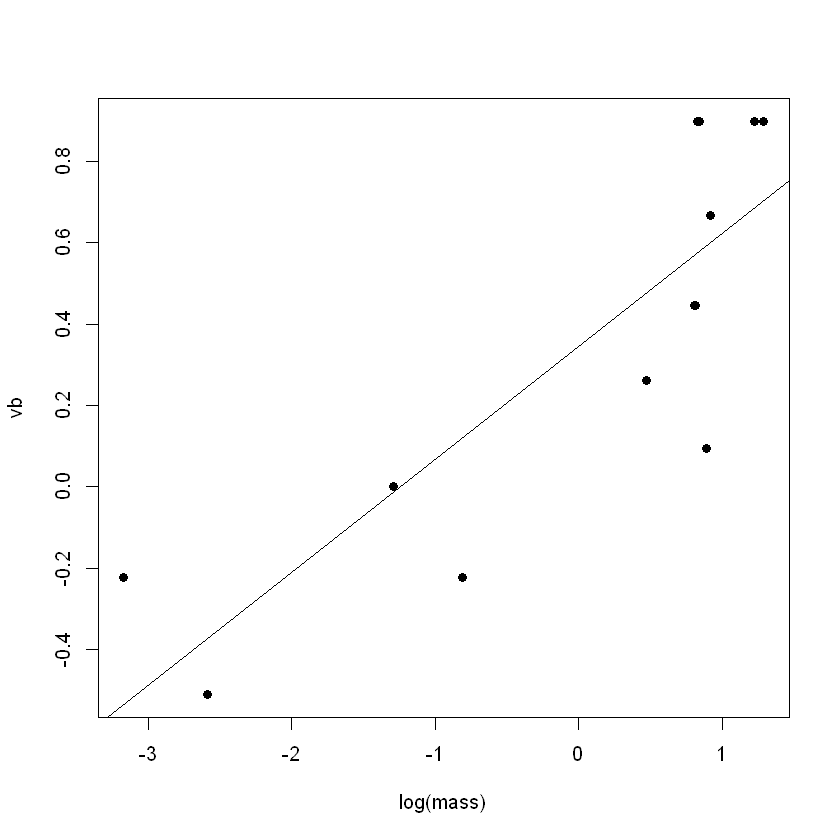

In [5]:
coefficients(trait)
plot(vb~mass, data=vb, pch=16, xlab="log(mass)")
abline(trait, col="black")

OK, so we've established a strong linear relationship between body mass and Vb. Now, let's predict the Vb of the remaining frugivorous lemurs with their body mass.

In [6]:
output=matrix(nrow=length(topredict$mass), ncol=4)
for (i in 1:length(topredict$mass)){
    newdata <- data.frame(mass=topredict$mass[i])
    output[i,1:3] <- predict(trait, newdata, interval="confidence")
    output[i,-1] <- exp(output[i,1])*10
}
colnames(output) <- c("Predicted Vb (log)", "Low-Interval", "High-Interval", "Predicted Vb (mm)")
rownames(output) <- topredict$Species
head(output  )                              # predicted vb values and their 95% confidence intervals

,Predicted Vb (log),Low-Interval,High-Interval,Predicted Vb (mm)
Archaeolemur_majori,1.150866,31.60930,31.60930,31.60930
Babakotia_ radofilai,1.186581,32.75862,32.75862,32.75862
Hadropithecus_stenognathus,1.335470,38.01784,38.01784,38.01784
Megaladapis_edwardsi,1.545271,46.89243,46.89243,46.89243
Mesopropithecus_globiceps,1.000870,27.20648,27.20648,27.20648
Palaeopropithecus_ingens,1.445353,42.43351,42.43351,42.43351


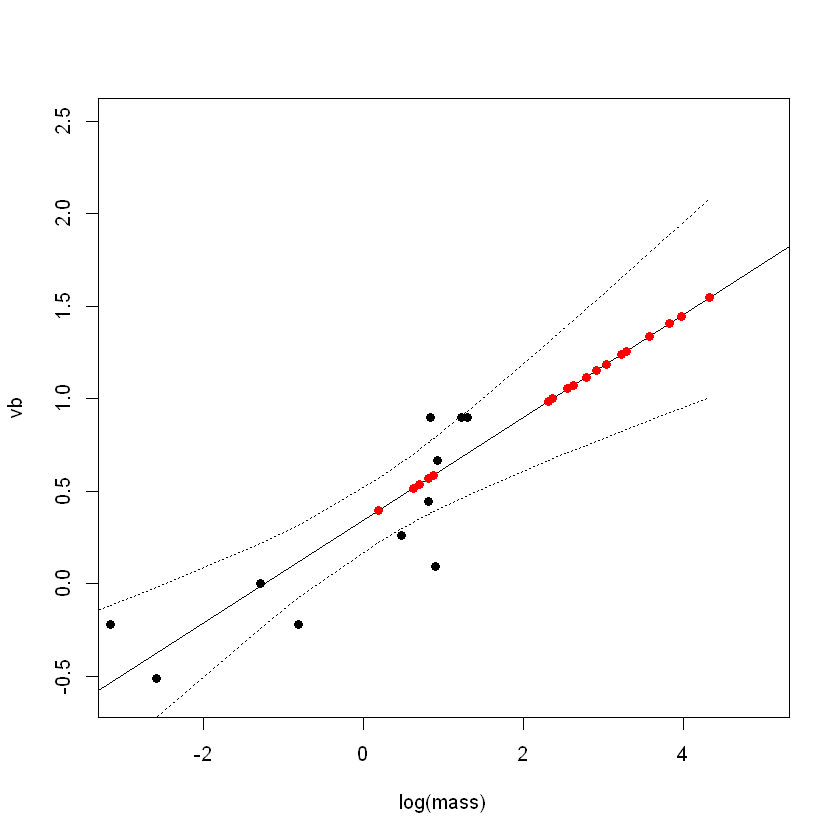

In [7]:
plot(vb~mass, data=vb, ylim=c(-0.6,2.5), xlim=c(-3,5), col="black", pch=16, xlab="log(mass)")
abline(trait, col="black")

## map the predicted Vb values onto the regression line
points(topredict$mass,output[,1], col= "red", pch=16)

## make a vector of all body mass data so that we can plot the 95% confidence intervals
newx<-sort(c(vb$mass, topredict$mass))

## generate confidence intervals for the entire dataset
a<-predict(trait, newdata=data.frame(mass=newx), interval="confidence")

## add 95% confidence interval lines
lines(newx, a[,2], lty=3)
lines(newx, a[,3], lty=3)

<br>
<br>
## Prepare imputed plant datasets

In [8]:
planttraitimp <-read.csv("PT-data-mice2.csv", header=T,sep=",")
summary(planttraitimp)

      .imp                       .id                   Gen        
 Min.   : 0   Abrahamia_buxifolia  :    21   Bulbophyllum:  3969  
 1st Qu.: 5   Abrahamia_deflexa    :    21   Impatiens   :  3633  
 Median :10   Abrahamia_ditimena   :    21   Dypsis      :  3423  
 Mean   :10   Abrahamia_grandidieri:    21   Dombeya     :  3255  
 3rd Qu.:15   Abrahamia_humbertii  :    21   Croton      :  3024  
 Max.   :20   Abrahamia_ibityensis :    21   Euphorbia   :  2667  
              (Other)              :184338   (Other)     :164493  
            Fam                       Clade2       Lform3          FrType2     
 Orchidaceae  : 15771   asterids         :67620   HE  :39334   capsule :76332  
 Rubiaceae    : 14175   basal angiosperms: 6636   LI  :25762   drupe   :35500  
 Acanthaceae  :  9933   eudicots         : 6258   SH  :64711   berry   :26297  
 Euphorbiaceae:  9660   gymnosperm       :  126   Tree:54441   achene  :18114  
 Fabaceae     :  9429   monocots         :36561   NA's:  216   f

In [42]:
## Keep only imputed datasets (1=>20) by removing the original dataset (0)
planttraitimp2 <-planttraitimp[ ! planttraitimp$.imp== "0", ]

In [43]:
## Give proper class to variables
planttraitimp2$.imp<-as.factor(planttraitimp2$.imp)
planttraitimp2$Rarity3 <- factor(planttraitimp2$Rarity3, order = TRUE, levels = c("0", "1", "2", "3"))

We will create some additional variables by combining some of the old ones. This will makes the analyses easier.

In [44]:
## Combine pulp types into two categories: pulp/no_pulp
planttraitimp2$Pulp3 <- ifelse(planttraitimp2$Pulp2=="NA", "NA",
	ifelse(planttraitimp2$Pulp2=="no", "no_pulp", "pulp"))
planttraitimp2$Pulp3 <- factor(planttraitimp2$Pulp3)

## Combine bioclimates
planttraitimp2$Clim_Humid2<- ifelse(planttraitimp2$Clim_Humid=="NA", "NA",
	ifelse(planttraitimp2$Clim_Humid=="yes"|planttraitimp2$Clim_Subhumid=="yes"| planttraitimp2$Clim_Montane=="yes","yes", "no"))
planttraitimp2$Clim_Humid2 <- factor(planttraitimp2$Clim_Humid2)

planttraitimp2$Clim_Dry2<- ifelse(planttraitimp2$Clim_Humid=="NA", "NA",
	ifelse(planttraitimp2$Clim_Subarid=="yes"|planttraitimp2$Clim_Dry=="yes","yes", "no"))
planttraitimp2$Clim_Dry2 <- factor(planttraitimp2$Clim_Dry2)

## Combine vegetation formations
planttraitimp2$Veg_Closed<- ifelse(planttraitimp2$Veg_Forest=="NA", "NA",
	ifelse(planttraitimp2$Veg_Forest=="yes"|planttraitimp2$Veg_Bush=="yes", "yes", "no"))
planttraitimp2$Veg_Closed <- factor(planttraitimp2$Veg_Closed)

planttraitimp2$Veg_OnlyForest<- ifelse(planttraitimp2$Veg_Forest=="NA", "NA",
	ifelse(planttraitimp2$Veg_Forest=="yes" & planttraitimp2$Veg_Bush=="no" & planttraitimp2$Veg_Shrub=="no" & planttraitimp2$Veg_Grass=="no" & planttraitimp2$Veg_Mang=="no" & planttraitimp2$Veg_Anthr=="no" ,"yes", "no"))
planttraitimp2$Veg_OnlyForest <- factor(planttraitimp2$Veg_OnlyForest)

Now, we have to assign seed dispersal syndromes to each plant species.

But, what's a __seed dispersal syndrome__?<br>
It is a set of fruit/seed/plant traits used to predict the most likely dispersal agents. For example, when we have a seed with a pappus or a wing, then it is likely to be dispersed by wind (anemochory). If a seed displays hooks, then it is probably dispersed while attached to the fur of animals (epizoochory). Fleshy fruits are mainly dispersed through the guts of animals (endozoochory).

So, first, we define __endozoochorous__ (with pulp or mimetic seeds) and non-endozoochorous species, to separate plant species that are dispersed by animals from other plant species.

In [45]:
# endozoochorous (biotic)/non-endozoochorous (abiotic)
planttraitimp2$SyndAB2 <- ifelse(planttraitimp2$Pulp3=="NA", "NA",
	ifelse(planttraitimp2$Gen=="Adenanthera"|planttraitimp2$Gen=="Erythrina"|planttraitimp2$.id=="Abrus_aureus"|planttraitimp2$.id=="Abrus_diversifoliolatus"|planttraitimp2$.id=="Abrus_parvifolius", "Biotic",		# mimetic seeds
		ifelse(planttraitimp2$Pulp3=="pulp", "Biotic","Abiotic")))
planttraitimp2$SyndAB2 <- factor(planttraitimp2$SyndAB2)

Then, among animal_dispersed plant species, we define the bird-syndrome and the primate-syndrome as following:<br>
* __primate-dispersed__ species: diaspores with green, brown or white colour (e.g. Adansonia spp.)
* __bird-dispersed__ species: diaspores with thin fruit husk or without fruit husk, and contrasting, purple or blue colour (e.g. Commiphora spp.)

*Note: When we say that a species displays a primate-syndrome, it doesn't mean that it is dispersed only by primates. It just means that this species is probably best adapted to be dispersed by primates but it can still be dispersed (though probably less effectively) by other dispersers. A plant species often has a variety of dispersers.*

In [46]:
# syndBPMAD4 =  colour 
planttraitimp2$SyndBPMAD4 <- ifelse(planttraitimp2$Dcol2=="NA", "NA",
	ifelse(planttraitimp2$SyndAB2=="Abiotic", NA,
		ifelse(planttraitimp2$Gen=="Eriosema"|planttraitimp2$Gen=="Oxalis", NA,
			ifelse(planttraitimp2$Dcol2=="contrast"|planttraitimp2$Dcol2=="blue"|planttraitimp2$Dcol2=="purple", "Bird",
				ifelse(planttraitimp2$Dcol2=="green"|planttraitimp2$Dcol2=="brown"|planttraitimp2$Dcol2=="white", "Primate", NA)))))
planttraitimp2$SyndBPMAD4 <- factor(planttraitimp2$SyndBPMAD4)


# syndBPMADH4 =  colour + husk
planttraitimp2$SyndBPMADH4 <- ifelse(planttraitimp2$Dcol2=="NA", "NA",
	ifelse(planttraitimp2$SyndAB2=="Abiotic", NA,
		ifelse(planttraitimp2$Gen=="Eriosema"|planttraitimp2$Gen=="Oxalis", NA,
			ifelse(planttraitimp2$FrHusk2=="thick", "Primate",
				ifelse(planttraitimp2$Dcol2=="contrast"|planttraitimp2$Dcol2=="blue"|planttraitimp2$Dcol2=="purple", "Bird",
					ifelse(planttraitimp2$Dcol2=="green"|planttraitimp2$Dcol2=="brown"|planttraitimp2$Dcol2=="white", "Primate", NA))))))
planttraitimp2$SyndBPMADH4 <- factor(planttraitimp2$SyndBPMADH4)

Now, it is time to count the __number of potential seed dispersers__ for each plant species. <br>
We will use the data on animals that we have already prepared.<br>
We will compare the seed size of each plant and the size of the largest seed able to be ingested by each disperser.<br>
To have a comprehensive count, we won't focus on primate/bird-syndromes and take into account all endozoochorous species.

In [50]:
planttraitimp2$SeWi <- exp(planttraitimp2$log_SeWi)
planttraitimp2$SeWi <- as.numeric(planttraitimp2$SeWi)

# Number of potential primate dispersers
planttraitimp2$Nprimate <-ifelse(planttraitimp2$Pulp3=="no_pulp", NA,
	ifelse(planttraitimp2$SeWi<=5.3, 20,                                       # any seed smaller than 5.3 mm may be ingested by any of the 20 lemur dispersers 
		ifelse(planttraitimp2$SeWi>5.3 & planttraitimp2$SeWi<=6, 19,           # any seed between 5.3 and 6 mm may be ingested by 19 lemur dispersers
			ifelse(planttraitimp2$SeWi>6 & planttraitimp2$SeWi<=8, 18,         # any seed between 6 and 8 mm may be ingested by 18 lemur dispersers
				ifelse(planttraitimp2$SeWi>8 & planttraitimp2$SeWi<=10, 16,    # ...
					ifelse(planttraitimp2$SeWi>10 & planttraitimp2$SeWi<=11, 15,
					ifelse(planttraitimp2$SeWi>11 & planttraitimp2$SeWi<=13, 14,
					ifelse(planttraitimp2$SeWi>13 & planttraitimp2$SeWi<=14.9, 13,
					ifelse(planttraitimp2$SeWi>14 & planttraitimp2$SeWi<=15.6, 12,
					ifelse(planttraitimp2$SeWi>15.6 & planttraitimp2$SeWi<=16.8, 10,
					ifelse(planttraitimp2$SeWi>16.8 & planttraitimp2$SeWi<=17.1, 9,
					ifelse(planttraitimp2$SeWi>17.1 & planttraitimp2$SeWi<=17.7, 7,
					ifelse(planttraitimp2$SeWi>17.7 & planttraitimp2$SeWi<=18, 6,
					ifelse(planttraitimp2$SeWi>18 & planttraitimp2$SeWi<=19.5, 5,
					ifelse(planttraitimp2$SeWi>19.5 & planttraitimp2$SeWi<=24.55, 4,0)))))))))))))))
planttraitimp2$Nprimate <- as.numeric(planttraitimp2$Nprimate)


# Number of potential bird dispersers
planttraitimp2$Nbird <-ifelse(planttraitimp2$SyndAB2=="Abiotic", NA,
	ifelse(planttraitimp2$SeWi<=4.9, 5,
		ifelse(planttraitimp2$SeWi>4.9 & planttraitimp2$SeWi<=6, 3,
			ifelse(planttraitimp2$SeWi>6 & planttraitimp2$SeWi<=10.7, 2,
				ifelse(planttraitimp2$SeWi>10.7 & planttraitimp2$SeWi<=11.88, 1,0)))))
planttraitimp2$Nbird <- as.numeric(planttraitimp2$Nbird)


# Number of potential bat dispersers
planttraitimp2$Nbat <-ifelse(planttraitimp2$Pulp3=="no_pulp", NA,
	ifelse(planttraitimp2$SeWi<=3, 3,
		ifelse(planttraitimp2$SeWi>3 & planttraitimp2$SeWi<=6.43, 2,
			ifelse(planttraitimp2$SeWi>6.43 & planttraitimp2$SeWi<=9.6, 1,0))))
planttraitimp2$Nbat <- as.numeric(planttraitimp2$Nbat)


# Total number of dispersers
planttraitimp2$Total_disp<-apply(planttraitimp2[,c("Nbird","Nprimate","Nbat")],1,function(x){z <- x[!is.na(x)]; ifelse(length(z), sum(z), NA)})
planttraitimp2$Total_disp <- as.numeric(planttraitimp2$Total_disp)

Some plant species have 0 potential disperser. Their seeds are too large to be dispersed by any extant disperser. They were probably adapted to be dispersed by now extinct large animals (giant lemurs, elephant birds...). <br>
That's why we define these plants as __anachronistic__.

In [51]:
# Anachronistic species
planttraitimp2$AnachSeExtr<-ifelse(planttraitimp2$Nbird=="NA", "NA",
	ifelse(planttraitimp2$Total_disp == 0, "yes", "no"))
planttraitimp2$AnachSeExtr <- factor(planttraitimp2$AnachSeExtr)

In [52]:
summary(planttraitimp2)

      .imp                           .id                   Gen        
 1      :  8784   Abrahamia_buxifolia  :    20   Bulbophyllum:  3780  
 2      :  8784   Abrahamia_deflexa    :    20   Impatiens   :  3460  
 3      :  8784   Abrahamia_ditimena   :    20   Dypsis      :  3260  
 4      :  8784   Abrahamia_grandidieri:    20   Dombeya     :  3100  
 5      :  8784   Abrahamia_humbertii  :    20   Croton      :  2880  
 6      :  8784   Abrahamia_ibityensis :    20   Euphorbia   :  2540  
 (Other):122976   (Other)              :175560   (Other)     :156660  
            Fam                       Clade2       Lform3          FrType2     
 Orchidaceae  : 15020   asterids         :64400   HE  :37494   capsule :72756  
 Rubiaceae    : 13500   basal angiosperms: 6320   LI  :24560   drupe   :33833  
 Acanthaceae  :  9460   eudicots         : 5960   SH  :61707   berry   :25060  
 Euphorbiaceae:  9200   gymnosperm       :  120   Tree:51919   achene  :17266  
 Fabaceae     :  8980   monocots

In [ ]:
# Save the data
write.table(planttraitimp2, file="PT-data-miceP.csv", sep=",",row.names=FALSE)

<br>
<br>
## Some descriptive Statistics

Let's see whether we can get some insights into the data.

In [10]:
# Load data
planttraitimp <- read.csv("PT-data-miceP.csv", header=T,sep=",")

# Give proper class to variables
planttraitimp$.imp<-as.factor(planttraitimp$.imp)
planttraitimp$Rarity3 <- factor(planttraitimp$Rarity3, order = TRUE, levels = c("0", "1", "2", "3"))
planttraitimp$log_FrLe<-as.numeric(planttraitimp$log_FrLe)
planttraitimp$log_FrWi<-as.numeric(planttraitimp$log_FrWi)
planttraitimp$log_SeWi<-as.numeric(planttraitimp$log_SeWi)
planttraitimp$SeFr<-as.numeric(planttraitimp$SeFr)
planttraitimp$SyndAB2 <- factor(planttraitimp$SyndAB2)
planttraitimp$AnachSeExtr <- factor(planttraitimp$AnachSeExtr)

# Format the file
implist<-split(planttraitimp, list(planttraitimp$.imp))
implist<-implist[-1]

In [63]:
library(miceadds);

# Percentage of each level of factor in the Madagascan flora
varnames3 <- c("SyndAB2", "SyndBPMAD4", "SyndBPMADH4", "Veg_Closed","Veg_OnlyForest")
for (i in seq_along(varnames3)) {
    listvar<-lapply(implist, `[`, varnames3[i])	# list with each imputed dataset as elements, with only one variable (varnames3[i])
    tabfun<-function(x) table(x,useNA="always")
    freq1 <- sapply(listvar, tabfun)		# calculate the frequency of each level in each dataset
    grandm <- apply(freq1,1, mean)			# calculate the mean of frequencies of each level
    names(grandm)[length(grandm)] <- "NAs"
    grandm2<- as.data.frame(grandm)
    colnames(grandm2)<-"frequency"
    grandm2$percent <- round(grandm2$freq/sum(grandm2$freq)*100,2)
    output.format1(stringtype="." , label =varnames3[i], rep.N=1 ,stringlength = 40)	
    print(grandm2)
}


........................................
SyndAB2

        frequency percent
Abiotic  5459.842   62.16
Biotic   3324.158   37.84
NAs         0.000    0.00

........................................
SyndBPMAD4

        frequency percent
Bird     640.3684    7.29
Primate  852.1579    9.70
NAs     7291.4737   83.01

........................................
SyndBPMADH4

        frequency percent
Bird     556.6842    6.34
Primate 1375.0526   15.65
NAs     6852.2632   78.01

........................................
Veg_Closed

    frequency percent
no   2155.368   24.54
yes  6628.632   75.46
NAs     0.000    0.00

........................................
Veg_OnlyForest

    frequency percent
no   3555.474   40.48
yes  4017.000   45.73
NAs  1211.526   13.79


<div class="alert alert-block alert-success">
We have several interesting outputs: <br>
1) __Only 1/3 of the Madagascan plant species are endozoochorous__, which is low compared to other tropical areas.<br>
2) __Primate-dispersed plants dominate__, contrary to other tropical areas where bird-dispersed plants form the majority (whatever the definition SyndBPMAD4 or SyndBPMADH4. <br>
3) 3/4 of the Madagascan flora occur in __closed vegetation__ (i.e. forest, woodland, bushland or thicket). <br>
4) Just under half the species (46%) were __only found in forests__! Given the high deforestation rate in Madagascar. We have to worry a lot!